## MALA

In this notebook I will implement the Metropolis Adjusted Langevin Algorithm (MALA) and the Random Walk Metropolis (RWM) algorithm for comparison.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

***
### RWM 

The RWM algorithm works as follows: initialize and for j = 1,2,.. propose 
\begin{align}
u' = u_j + h \xi_j,
\end{align}
with $\xi_j \sim \mathcal{N}(0,1)$ and step size $h$. 

Accept this move with acceptance probability
\begin{align}
\alpha (u'|u_j) &= \text{min}\left (1,\frac{\pi(u')}{\pi(u_j)} \right ),
\end{align}
because $q(u_j|u')=q(u'|u_j)$ for this algorithm.
If the move is accepted then $u_{j+1} = u'$, otherwise $u_{j+1} = u_j$.

I have implemented the algorithm below for $\pi(\mathbf{x})=\prod_{i=1}^{d} (2\pi)^{-1/2} \text{exp}\left (-(x^{(i)})^2/2 \right ), \ \mathbf{x}=(x^{(1)},\cdots,x^{(d)}) \in \mathbb{R}^{d}$
with an adaptive step size, such that the optimal acceptance probability of 0.234 can be obtained. 

In [15]:
def RWM_adaptivevariance(Xzero,Dt,d,N):
    """
    The RWM algorithm with adaptive step size. It takes as input:
    initial condition Xzero, initial step size Dt, Markov Chain dimension d, and number of samples M.
    It outputs the average acceptance probability alpha and the average proposal step size.
    """
    
    X = np.zeros((N,d))  
    X[0,:] = Xzero       
    alpham = []          # Will store the acceptance probabilities in here
    Dtprop = np.zeros(N) # Will store the step sizes in here
    Dtprop[0] = Dt       

    for j in range(N-1):
        Xprop = X[j,:]+Dt*np.random.randn(d) 
        
        # Compute acceptance probability
        alpha = np.min([1,np.exp(0.5*(np.sum(X[j,:]**2)-np.sum(Xprop**2)))])
        
        # Decide whether or not to accept
        r = np.random.rand(1) 
        if r < alpha:         
            X[j+1,:] = Xprop      # Accepted the proposal!
        else:                 
            X[j+1,:] = X[j,:]     # Did not accept. X_(j+1) = X_j
        
        alpham += [[alpha]] # Store acceptance probability for this iteration
        
        Dt += (Dt/(j+1))*(alpha-0.234)   # Update the proposal variance using the current acceptance probability and the desired one
        Dtprop[j+1] = Dt                 # Store proposal variance for this iteration
        
    return np.mean(alpham),np.mean(Dtprop) 

***
### MALA
Consider the first-order SDE
\begin{align}
\text{d}X = \nabla \text{log} \pi(X) \text{d}t + \sqrt{2}\text{d}W
\end{align}
Using Euler-Maruyama this gives
\begin{align}
X_{n+1} = X_n + \Delta t \nabla \text{log} \ \pi(X_n) + \sqrt{2\Delta t}\xi_n, \ \xi_n \sim \mathcal{N}(0,I_d).
\end{align}
This results in the proposal for MALA:
\begin{align*}
u' &= u_j + \Delta t \nabla \text{log} \ \pi(u_j) + \sqrt{2\Delta t}\xi_j,
\end{align*}
where $\xi_j \sim \mathcal{N}(0,I)$. MALA uses a Metropolis-Hasting acceptance step (in contrast with ULA) to ensure that the correct stationary distribution is obtained. 

The proposal $u'$ is accepted with acceptance probability
\begin{align}
\alpha (u'|u_j) &= \text{min}\left (1,\frac{\pi(u')q(u_j|u')}{\pi(u_j)q(u'|u_j)} \right ).
\end{align}
If the move is accepted then $u_{j+1} = u'$, otherwise $u_{j+1} = u_j$. <br>
I have implemented the algorithm with an adaptive step size, such that the optimal acceptance probability of 0.576 can be obtained.

In [16]:
import numpy as np

def MALA_adaptivevariance(Xzero,Dt,d,N):
    """
    The MALA algorithm with adaptive stepsize. It takes as input:
    initial condition Xzero, initial step size Dt, Markov Chain dimension d, and number of samples N.
    It outputs the average acceptance probability alpha and the average proposal step size.
    """

    X = np.zeros((N,d))  
    X[0,:] = Xzero       
    alpham = []          # Will store the acceptance probabilities in here
    Dtprop = np.zeros(N) # Will store the proposal variances in here
    Dtprop[0] = Dt       
    
    for j in range(N-1): 
        Xprop = X[j,:]-0.5*Dt*X[j,:]+np.sqrt(Dt)*np.random.randn(d)
        qX = np.exp(-(1/(4*0.5*Dt))*np.dot((X[j,:]+(0.5*Dt-1)*Xprop).T,(X[j,:]+(0.5*Dt-1)*Xprop)))
        qprop = np.exp(-(1/(4*0.5*Dt))*np.dot((Xprop+(0.5*Dt-1)*X[j,:]).T,(Xprop+(0.5*Dt-1)*X[j,:])))
        alpha = np.min([1,np.exp(0.5*(np.sum(X[j,:]**2)-np.sum(Xprop**2)))*(qX/qprop)])
        
        # Decide whether or not to accept
        r = np.random.rand(1)  
        if r < alpha:          
            X[j+1,:] = Xprop       # Accepted the proposal! 
        else:                  
            X[j+1,:] = X[j,:]      # Did not accept. X_(j+1) = X_j
        
        alpham += [[alpha]] # Store acceptance probability for this iteration
        
        Dt += (Dt/(j+1))*(alpha-0.576)   # Update the proposal variance using the current acceptance probability and the desired one
        Dtprop[j+1] = Dt                  # Store proposal variance for this iteration
           
    return np.mean(alpham),np.mean(Dtprop)

In [20]:
# In this cell I will compute, for different choices of the dimension, the
# 1) average acceptance probability, 2) average proposal variance / step size
# for both the RWM algorithm as the MALA algorithm. 

# Hyperparameter settings
dimension = np.linspace(10,300,30) 
Dt = 0.1                # Initial proposal variance
N = 100000               # Number of samples

alpha_RWM = []          
alpha_MALA = []         
Dt_RWM = []             
Dt_MALA = []            

for i,dim in enumerate(dimension):   
    alpha,propvar = RWM_adaptivevariance(np.zeros(int(dim)),Dt,int(dim),N) # Run the RWM algorithm with adaptive step-size
    alpha_RWM += [[alpha]]    # Store the average acceptance probability for RWM
    Dt_RWM += [[propvar]]     # Store the evolution of the proposal variance for RWM
    
    alpha,propvar = MALA_adaptivevariance(np.zeros(int(dim)),Dt,int(dim),N) # Run the MALA algorithm with adaptive step-size
    alpha_MALA += [[alpha]] 
    Dt_MALA += [[propvar]]  

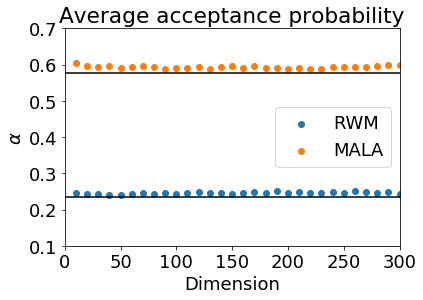

In [33]:
# In this cell I will plot the average acceptance probability (wrt dimension) for both the RWM and MALA algorithms
# The desired acceptance probability is indicated by a black line at 0.234 for RWM and at 0.576 for MALA
plt.rcParams.update({'font.size': 18}) 
plt.scatter(dimension,alpha_RWM,label="RWM")
plt.scatter(dimension,alpha_MALA,label="MALA")
plt.plot([0, 300], [0.234, 0.234],color='k')   
plt.plot([0, 300], [0.576, 0.576],color='k')  
plt.xlabel("Dimension")
plt.ylabel("$\\alpha$")
plt.ylim([0.1,0.7])
plt.xlim([0,300])
plt.title("Average acceptance probability")
plt.legend()

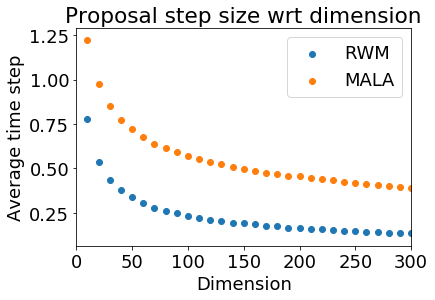

In [31]:
# In this cell I will plot the average of the proposal variance samples (wrt dimension) for both the RWM and MALA algorithms
plt.rcParams.update({'font.size': 18}) 
plt.scatter(dimension,Dt_RWM,label="RWM")    
plt.scatter(dimension,Dt_MALA,label="MALA")  
plt.xlabel("Dimension")
plt.ylabel("Average time step")
plt.title("Proposal step size wrt dimension")
plt.xlim([0,300])
plt.legend()

Clearly, the RWM algorithm has a much lower optimal step size than MALA. Together with MALA's higher acceptance rate, this means that MALA asymptotically mixes much faster than RWM. The MALA algorithm is thus superior.